## Implementation of MimiFAIR162-MimiFUND

This notebook implements a coupling of the MimiFAIR model and the MimiFUND model. At a high-level, the goal here is to use the MimiFAIR model as the climate module, and the MimiFUND model as the socioeconomic and damages modules, although in this case we still allow MimiFUND's climate module to take care of the modeling of non-CO₂ gases like methane.  

This is meant to be an instructional example for the use-case of Mimi where a user wishes to couple together existing models.

Resources for further inquiries include:

- The Mimi framework [website](https://www.mimiframework.org)
- The Mimi [forum](https://forum.mimiframework.org) for technical and Mimi-related questions
- The model-specific repositories, [MimiFUND](https://github.com/fund-model/MimiFUND.jl) and [MimiFAIR](https://github.com/anthofflab/mimi-fair.jl/) for model-specific inquiries

If you wish to follow alone, feel free to download or clone the Github repository, or create a new project on your own machine. If you are new to Mimi, you will probably want to start with our basic Mimi installation process as described in our documentation [here](https://www.mimiframework.org/Mimi.jl/stable/tutorials/tutorial_1/#Tutorial-1:-Install-Mimi-1).

### Set up the Environment

The first step is to set up the environment with the required packages and versions for this exercise as indicated in the `Manifest.toml` and `Project.toml` files. As you can see from the call to `Pkg.status()`, this work requires a few packages including the `master` branch of `Mimi`, the default (latest tagged) versions of `MimiFAIR` and `MimiFUND` model implementations, and some supporting packages `CSVFiles`, `DataFrames`, and `Vegalite`.

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating environment at `~/JuliaProjects/MimiModels/MimiFUND-MimiFAIR-Flat.jl/Project.toml`


      Status `~/JuliaProjects/MimiModels/MimiFUND-MimiFAIR-Flat.jl/Project.toml`
  [5d742f6a] CSVFiles v1.0.1
  [a93c6f00] DataFrames v1.2.2
  [e4e893b0] Mimi v1.3.3
  [73d86c50] MimiFAIR v1.0.2
  [02cc1f66] MimiFAIRv1_6_2 v0.1.0 `https://github.com/FrankErrickson/MimiFAIRv1_6_2.jl.git#main`
  [b3ba11de] MimiFUND v3.13.0
  [91a5bcdd] Plots v1.22.6
  [112f6efa] VegaLite v2.6.0


Note that if you are following along on your own machine without downloading this repository, you can recreate this environment by adding each of the packages listed above with `Pkg.add()`, or using the `Pkg` REPL entered with `]`.

In [2]:
# using Pkg
# Pkg.add("CSVFiles")
# Pkg.add("DataFrames")
# Pkg.add("Mimi")
# Pkg.add("MimiFAIR")
# Pkg.add("MimiFUND")
# Pkg.add("VegaLite")

# Pkg.status()

Next we load the packages whose APIs we will be directly using as well as set some constants to be used in the script.

In [3]:
using MimiFAIRv1_6_2
using MimiFUND
using Mimi


### Load Helpers and Set Constants

We will now load some helper functions and set some constants, most of which have to do with the difference in time dimensions between FAIR and FUND, which will drive much of our coupling work.


The `helper.jl` file defines the `update_MimiFAIR_params!` function with the following signature.  This is copied directly from the source code of `MimiFAIR.jl` and takes care of the calls to `update_param!`, `add_shared_param!`, and `connect_param!` that build up the stand alone MimiFAIR model.


```
function update_MimiFAIR_params!(m; rcp_scenario::String="RCP85", start_year::Int=1765, end_year::Int=2500, F2x::Float64=3.71, TCR::Float64=1.6, ECS::Float64=2.75, d::Array{Float64,1}=[239.0, 4.1])
```

In the future we can likely shorten this function by adding `default` values to the scalar parameters of FAIR.

In [4]:
include("src/helper.jl");

In [5]:
# set some constants
ar6_scenario = "ssp585"

FAIR_first = 1750
FAIR_last = 2300
FAIR_len = length(FAIR_first:FAIR_last)

FUND_first = 1950
FUND_last = 2300
FUND_len = length(FUND_first:FUND_last)

351

### Load Independent (Default) FUND and FAIR Models

We begin with the default FUND model as implemented in `MimiFUND.jl`.

In [6]:
m = MimiFUND.get_model()

Mimi.Model
  Module: Mimi
  Components:
    ComponentId(MimiFUND.scenariouncertainty)
    ComponentId(MimiFUND.population)
    ComponentId(MimiFUND.geography)
    ComponentId(MimiFUND.socioeconomic)
    ComponentId(MimiFUND.emissions)
    ComponentId(MimiFUND.climateco2cycle)
    ComponentId(MimiFUND.climatech4cycle)
    ComponentId(MimiFUND.climaten2ocycle)
    ComponentId(MimiFUND.climatesf6cycle)
    ComponentId(MimiFUND.climateforcing)
    ComponentId(MimiFUND.climatedynamics)
    ComponentId(MimiFUND.biodiversity)
    ComponentId(MimiFUND.climateregional)
    ComponentId(MimiFUND.ocean)
    ComponentId(MimiFUND.impactagriculture)
    ComponentId(MimiFUND.impactbiodiversity)
    ComponentId(MimiFUND.impactcardiovascularrespiratory)
    ComponentId(MimiFUND.impactcooling)
    ComponentId(MimiFUND.impactdiarrhoea)
    ComponentId(MimiFUND.impactextratropicalstorms)
    ComponentId(MimiFUND.impactforests)
    ComponentId(MimiFUND.impactheating)
    ComponentId(MimiFUND.impactvectorbor

We will now import each of the individual FAIR components.

In [7]:
# import MimiFAIRv1_6_2 components 
import MimiFAIRv1_6_2: ch4_cycle, n2o_cycle, other_ghg_cycles, co2_cycle, ch4_forcing, o3_forcing,
    n2o_forcing, other_ghg_forcing, other_ghg_cycles, co2_forcing, o3_depleting_substance_cycles, o3_depleting_substance_forcing, aerosol_direct_forcing, 
    aerosol_indirect_forcing, bc_snow_forcing, landuse_forcing, contrails_forcing, total_forcing, temperature 


### Add and Update Dimensions

The first step in building out our coupled model, starting with our default FUND model, is to handle dimensions. Currently the model `m` has two dimensions, `time` and `regions`. 

In [8]:
m.md.dim_dict # display the dimensions of the default FUND model

OrderedCollections.OrderedDict{Symbol, Union{Nothing, Mimi.Dimension}} with 3 entries:
  :time       => [1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959  ……
  :regions    => ["USA", "CAN", "WEU", "JPK", "ANZ", "EEU", "FSU", "MDE", "CAM"…
  Symbol("5") => [1, 2, 3, 4, 5]

We now add two new dimensions to our model `m` that are used by FAIR.

In [9]:
# add new dimensions relevant to FAIR (1) minor greenhouse gases and 
# (2) ozone-depleting substances
other_ghg_names = ["CF4", "C2F6", "C6F14", "HFC23", "HFC32", "HFC43_10", "HFC125", "HFC134a", "HFC143a", "HFC227ea", "HFC245fa", "SF6"]
ods_names       = ["CFC_11", "CFC_12", "CFC_113", "CFC_114", "CFC_115", "CARB_TET", "MCF", "HCFC_22", "HCFC_141B", "HCFC_142B", "HALON1211", "HALON1202", "HALON1301", "HALON2402", "CH3BR", "CH3CL"]

set_dimension!(m, :other_ghg, other_ghg_names) # FAIR dims - Set index for Kyoto and ozone ozone-depleting gases.
set_dimension!(m, :ozone_depleting_substances, ods_names) # FAIR dims - Set index for Kyoto and ozone ozone-depleting gases.

m.md.dim_dict  # display the (augmented) dimensions of the default FUND model's Model Definition

OrderedCollections.OrderedDict{Symbol, Union{Nothing, Mimi.Dimension}} with 5 entries:
  :time                       => [1950, 1951, 1952, 1953, 1954, 1955, 1956, 195…
  :regions                    => ["USA", "CAN", "WEU", "JPK", "ANZ", "EEU", "FS…
  Symbol("5")                 => [1, 2, 3, 4, 5]
  :other_ghg                  => ["CF4", "C2F6", "C6F14", "HFC23", "HFC32", "HF…
  :ozone_depleting_substances => ["CFC_11", "CFC_12", "CFC_113", "CFC_114", "CF…

The final dimensions-related step is to expand the time dimension of the model.  At this stage, our model runs on FUND's default time dimension 1950 to 3000 (`FUND_first` to `FUND_last`).  FAIR, however, runs from 1765 to 2500 (`FAIR_first` to `FAIR_last`) so we are going to set our model to run from 1765 to 2500.

FUND will not start running until 1950, and will not produce an `emissions` value until 1951, so up until 1951 FAIR will use `backup` values pulled from default FUND as we will describe in detail below.

**For further details on the effects and restrictions around updating the `time` dimension of a model see the documentation [here](https://www.mimiframework.org/Mimi.jl/dev/howto/howto_5/).**

In [10]:
set_dimension!(m, :time, collect(FAIR_first:FAIR_last))

m.md.dim_dict # display the (udpated) dimensions of the model

OrderedCollections.OrderedDict{Symbol, Union{Nothing, Mimi.Dimension}} with 5 entries:
  :time                       => [1750, 1751, 1752, 1753, 1754, 1755, 1756, 175…
  :regions                    => ["USA", "CAN", "WEU", "JPK", "ANZ", "EEU", "FS…
  Symbol("5")                 => [1, 2, 3, 4, 5]
  :other_ghg                  => ["CF4", "C2F6", "C6F14", "HFC23", "HFC32", "HF…
  :ozone_depleting_substances => ["CFC_11", "CFC_12", "CFC_113", "CFC_114", "CF…

### Augment FUND with FAIR Components

We now add the FAIR components to our model.  We place them in a contiguous block starting after the FUND `emissions` component, which will feed results into the FAIR components before FAIR feeds back into FUND from its `temperature` component.

Also note that since we have updated the time dimension to run from `FAIR_first` to `FAIR_last`, or 1765 to 2500, each of these new components will be set to run from 1765 to 2500, the full model time period, by default.

In [11]:
add_comp!(m, ch4_cycle; after = :emissions);
add_comp!(m, n2o_cycle; after = :ch4_cycle);
add_comp!(m, co2_cycle; after = :n2o_cycle);
add_comp!(m, other_ghg_cycles; after = :co2_cycle);
add_comp!(m, o3_depleting_substance_cycles; after = :other_ghg_cycles);
add_comp!(m, co2_forcing; after = :o3_depleting_substance_cycles);
add_comp!(m, ch4_forcing; after = :co2_forcing);
add_comp!(m, n2o_forcing; after = :ch4_forcing);
add_comp!(m, o3_forcing; after = :n2o_forcing);
add_comp!(m, aerosol_direct_forcing; after = :o3_forcing);
add_comp!(m, aerosol_indirect_forcing; after = :aerosol_direct_forcing);
add_comp!(m, other_ghg_forcing; after = :aerosol_indirect_forcing);
add_comp!(m, o3_depleting_substance_forcing; after = :other_ghg_forcing);
add_comp!(m, contrails_forcing; after = :o3_depleting_substance_forcing);
add_comp!(m, bc_snow_forcing; after = :contrails_forcing);
add_comp!(m, landuse_forcing; after = :bc_snow_forcing);
add_comp!(m, total_forcing; after = :landuse_forcing);
add_comp!(m, temperature; after = :total_forcing);

Next we run our helper function to update all the FAIR component parameters and make their internal connections, such that we have added  a fully functional and runnable FAIR model into our FUND model.


In [12]:
update_MimiFAIR162_params!(m; start_year = FAIR_first, end_year = FAIR_last, ar6_scenario = ar6_scenario)

ssp585


At this point the model `m` is runnable (and in fact none of the steps in this notebook thus far have made an invalid, unrunnable model), but currently `m` will run FUND and FAIR in their default modes and completely disconnected.  The next section describes the steps to couple them together.

### Couple FUND and FAIR

#### FUND Emissions --> Convert Mtons to Gtons --> FAIR CO₂ Cycle

We want to connect the FUND `emissions` component's `mco2` variable the FAIR `co2_cycle` component's `E_CO₂` parameter.  In the stand-alone version of FAIR, the `E_CO₂` is exogenously forced by the summation of all `CO₂` sources, as shown in it's source code (and the `helper.jl` file):

```
rcp_emissions, volcano_forcing, solar_forcing, gas_data, gas_fractions, conversions = MimiFAIR.load_fair_data(start_year, end_year, rcp_scenario)

update_param!(m, :co2_cycle, :E_CO₂, rcp_emissions.FossilCO2 .+ rcp_emissions.OtherCO2)
```

First we need to add a `multiplier` component between FUND's `emissions` component and the FAIR components because FUND outputs Mtons of C but FAIR expects Gtons of C. **Note that these models expect C instead of CO₂, which is endogenous to the model so we must align with those**.

Mimi has a few built in components for this type of situation, including `Mimi.multiplier`, as decribed [here](https://www.mimiframework.org/Mimi.jl/stable/tutorials/tutorial_3/#Component-and-Structural-Modifications:-The-API-1).  

This small component just needs a connected `input` parameter and a `multiply` parameter to produce an `output` variable. In this case, we connect the `multiplier` component's `input` parameter to the `emissions` component's `mco2` variable and set `multiply` parameter to our unit conversion value of 1/1000. We also set the `multiplier` component to run only while FUND runs by setting `first = FUND_first` and `last = FUND_last`.

In [13]:
add_comp!(m, Mimi.multiplier; after = :emissions, first = FUND_first, last = FUND_last);
set_param!(m, :multiplier, :multiply, fill(1/1000, FAIR_len)) # convert Mtons C coming out of FUND to Gtons C going into FAIR
connect_param!(m, :multiplier, :input, :emissions, :mco2)

Now that we have taken care of unit conversion, we can connect the FAIR `co2_cycle` component's `E_CO₂` parameter to the `multiplier` component's `output` variable.  A few notes on the arguments having to do with backup data are:

- Since FAIR runs from 1765 to 1950, but FUND (and the multiplier) only runs from 1950 to 2500, we need to include backup data `FAIR_CO₂_backup` for FAIR to use until FUND can provide a value.  We use the same data that previously exogenously forced FAIR.


- We also need to include the `backup_offset` optional argument for the `connect_param!` function, because FUND does not actually produce a value for `mco2` until it's *second* timestep, or in this case 1951, and thus we set `backup_offset = 1`.

In [15]:
# destination: FAIR component :co2_cycle parameter :E_CO₂
# previous source: exogenous parameter
# new source: FUND :emissions variable :mco2 (which first runs through the multiplier component)

# Subset AR6 emissions to proper years.
ar6_emissions_raw = DataFrame(load(joinpath(@__DIR__, "data", "model_data", "AR6_emissions_"*ar6_scenario*"_1750_2300.csv")))
emission_indices = indexin(collect(FAIR_first:FAIR_last), ar6_emissions_raw.Year)
ar6_emissions = ar6_emissions_raw[emission_indices, :]

FAIR_CO₂_backup = (ar6_emissions.FossilCO2 .+ ar6_emissions.OtherCO2)
connect_param!(m, :co2_cycle, :E_co2, :multiplier, :output, FAIR_CO₂_backup, backup_offset = 1)

#### FAIR Temperature --> FUND CO₂ Cycle, Biodiversity, Ocean and Regional Climate Components

Now we want to connect FAIR's output temperature variable `T` from component `temperature` back into FUND, both to the `temp` parameter of the `climateco2cycle`, `biodiversity`, and `ocean` components and into the `inputtemp` parameter of the `climateregional` component.

In [16]:
# destination: FUND components :climateco2cycle, :biodiversity, :ocean --> parameter :temp
# previous source: FUND component :climatedynamics --> variable :temp
# new source: FAIR :temperature --> variable :T

connect_param!(m, :climateco2cycle, :temp, :temperature, :T)
connect_param!(m, :biodiversity, :temp, :temperature, :T)
connect_param!(m, :ocean, :temp, :temperature, :T)

In [17]:
# destination: FUND component :climateregional, parameter :inputtemp
# previous source: FUND component :climatedynamics --> variable :temp
# new source: FAIR component :temperature --> variable :T

connect_param!(m, :climateregional, :inputtemp, :temperature, :T)

### Run and Visualize

Now we can run our coupled model and visualize the results with the `explore`, `plot`, and indexing functions. We will also grab the default FUND and FAIR models for comparisons.

In [20]:
run(m) # coupled model

mfund = MimiFUND.get_model()
run(mfund)

mfair = MimiFAIRv1_6_2.get_model(;start_year = FAIR_first, end_year = FAIR_last, ar6_scenario = ar6_scenario)
run(mfair)

In [18]:
explore(m)

Electron.Window(Application(Base.PipeEndpoint(RawFD(53) paused, 0 bytes waiting), Process(`/Users/lisarennels/.julia/artifacts/3ba739a4ed073587d96415faecef10a5ccea63ba/Julia.app/Contents/MacOS/Julia /Users/lisarennels/.julia/packages/Electron/ILvWR/src/main.js /var/folders/1w/jm1h6fwj0t536vld2gxj7kzr0000gn/T/jlel-9b9b29d2deb511eb1d5aff9fefbabc00 /var/folders/1w/jm1h6fwj0t536vld2gxj7kzr0000gn/T/jlel-sn-9b9b79dadeb511eb15d77db571017392 VXek2G18giFo1CtUdUXGHM2NAsIB3vQu6W5tu9wvbA6quVOCz515TO0Aaxr2CPyxFp9O2OY8z3kQHoEI/TVJOvy5DpTkmq45grLuqqORQlj/67i5QDz6KzCKyQqG/1FDfNEqm4RZ5vhGSu2jk0uDTUsVFrD8NamvTPi4vcItqls=`, ProcessRunning), [1 window]), 1, true, Channel{Any}(128))

#### Compare Some Time Series

One interesting step might be to compare some time series between the different models.  We could use the `Mimi.plot` function (ie. `Mimi.plot(m, :temperature, :T`) but here we will use some custom written plot code with the `VegaLite` package.

In [21]:
using VegaLite
using DataFrames

##### Temperature

Here we compare the delta temperature trajectory between FAIR, FUND, and FUNDFAIR. Noting that from 1765 to 1950 our results in FUNDFAIR will match FAIR, and then in 1950 FUND will kick in as our driver of CO2 emissions calculations while FAIR will continue to drive temperature calculations for which it recieves CO2 emissions inputs from FUND.

In [22]:
fairvals = mfair[:temperature, :T]
fundfairvals =  m[:temperature, :T]
fundvals = vcat(
    fill(missing, length(FAIR_first:FUND_first)-1),
    mfund[:climateco2cycle, :temp][1:length(FUND_first:FAIR_last),:]
)
fundvals = fundvals[:,1]; # make a vector

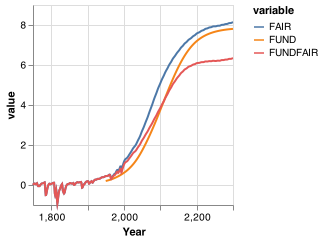

In [23]:
df = DataFrame(
    :Year => Mimi.time_labels(m),
    :FUND => fundvals,
    :FAIR => fairvals,
    :FUNDFAIR => fundfairvals
)

stack(df, [:FUND, :FAIR, :FUNDFAIR]) |> 

@vlplot(
    :line, 
    x = :Year,
    y = :value,
    color = :variable
)
    

##### Loss

Similarly, here we compare what the loss looks like when we use the FUND climate module for CO2 as compared to using the FAIR climate module for CO2.

In [24]:
fundfairvals = sum(m[:impactaggregation, :loss], dims = 2)[:,1];

fundvals = vcat(
    fill(missing, length(FAIR_first:FUND_first)-1),
    sum(mfund[:impactaggregation, :loss][1:length(FUND_first:FAIR_last),:], dims = 2)
)
fundvals = fundvals[:,1]; # make a vector

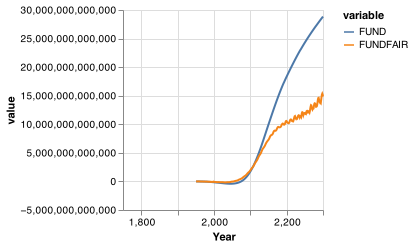

In [25]:
df = DataFrame(
    :Year => Mimi.time_labels(m),
    :FUND => fundvals, 
    :FUNDFAIR => fundfairvals)

stack(df, [:FUND, :FUNDFAIR]) |> 

@vlplot(
    :line, 
    x = :Year,
    y = :value,
    color = :variable
)

#### Quality Checking

We want to make sure that values are being passed between FUND and FAIR in the right units etc. so let's take a closer look at emissions.

##### Annual Carbon Dioxide Emissions (GtC yr⁻¹)

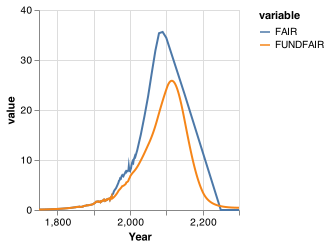

In [26]:
fairvals = mfair[:co2_cycle, :E_co2]
fundfairvals =  m[:co2_cycle, :E_co2]

df = DataFrame(
    :Year => Mimi.time_labels(m),
    :FAIR => fairvals, 
    :FUNDFAIR => fundfairvals)

stack(df, [:FAIR, :FUNDFAIR]) |> 

@vlplot(
    :line, 
    x = :Year,
    y = :value,
    color = :variable
)

In [25]:
##### Global Carbon Dioxide Emissions (MtC yr⁻¹)

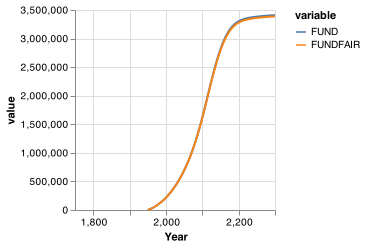

In [27]:
fundfairvals =  m[:emissions, :cumglobco2]
fundvals = vcat(
    fill(missing, length(FAIR_first:FUND_first)-1),
    sum(mfund[:emissions, :cumglobco2][1:length(FUND_first:FAIR_last),:], dims = 2)
)
fundvals = fundvals[:,1]; # make a vector

df = DataFrame(
    :Year => Mimi.time_labels(m),
    :FUND => fundvals, 
    :FUNDFAIR => fundfairvals)

stack(df, [:FUND, :FUNDFAIR]) |> 

@vlplot(
    :line, 
    x = :Year,
    y = :value,
    color = :variable
)

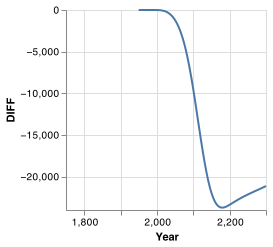

In [28]:
# difference between fundfair and fund in cumulative emissions since the graph above masks it out due 
# to scale

diffs = fundfairvals .- fundvals
DataFrame(:Year => Mimi.time_labels(m), :DIFF => diffs) |>
@vlplot(
    :line, 
    x = :Year,
    y = :DIFF,
)

In [29]:
# cumulative emissions value in 2020 - 2040
idxStart = findfirst(x -> x == 2020, Mimi.time_labels(m))
idxEnd = findfirst(x -> x == 2040, Mimi.time_labels(m))
fundfairvals[idxStart:idxEnd]

21-element Vector{Union{Missing, Float64}}:
 368378.28427284386
 377103.10120640724
 385949.08719491895
 394920.5442489212
 404021.93881396344
 413257.86762383534
 422627.5960521038
 432132.5649749397
 441774.31715773436
 451554.2960206777
 461473.9806521432
 471533.73002047476
 481735.30164614186
 492080.43180822296
 502570.794460061
 513208.1658445622
 523994.25941614195
 534930.7348512585
 546019.3323173702
 557261.7277639604
 568659.7058490447